In [1]:
import random
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
from pyomo_helpers import pretty_solution
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)

## Постановка задачи

Представим, что мы имеем 
- `v_reg`  — набор виртуальных регистров
- `phys_reg` — набор физических регистров
- базовый блок размера `basic_block_size`, который представляет собой последовательность инструкций. Каждая инструкция 
    - использует до  `инструкции_max` виртуальных регистров 
    - может быть определением нового виртуального регистра (а может и нет). 

Задача регистровой аллокации задаётся вопросом:

----
Есть ли отображение `v_reg` →  `phys_reg`, такое, что для любой инструкции образ её используемых регистров не будет содержать одинаковых физических регистров. 

----

Также мы предполагаем, что после использования регистра (??физического??) он сразу же сохраняется в памяти, а перед использованием из неё достаётся, что позволяет нам присваивать одинаковые физические регистры тем виртуальным регистрам, *live ranges* которых пересекаются. 

В настоящем аллокаторе, конечно же, для поиска оптимальных *spill/restore* промежутков используется отдельная эвристика жадного «разрезания», старающая минимизировать количество операций с памятью). 

Оптимизационная версия задачи «минимальная локальная регистровая аллокация», задаёт вопрос об аллокации минимальной стоимости, то есть минимизируем сумму использования регистра $N$ на стоимость использования $S_N$ по всем операндам всех инструкций.

In [33]:
#phys_regs_amount = 3 — слишком скучный вариант
phys_regs_amount = 4
phys_regs_costs = np.arange(1, phys_regs_amount + 1)

basic_block_size = 16
instruction_uses_max = int(phys_regs_amount / 2)  # при phys_regs_amount = 3 — тут будет 1, слишком скучный вариант
#instruction_uses_max = int(phys_regs_amount * 3 / 4)  # при phys_regs_amount = 3 — тут будет 1, слишком скучный вариант

virtual_alives = [0, 1]
virtual_uses = []

for _ in range(basic_block_size):
    # Каждая инструкция использует до instruction_uses_max виртуальных регистров
    virtual_uses.append([f"{i:02}" for i in np.random.choice(virtual_alives, instruction_uses_max)])
    
    # Инструкция с шансом 0.5 может определить новый виртуальный регистр
    if np.random.choice([True, False]):
        virtual_alives.append(virtual_alives[-1] + 1)

In [34]:
virtual_uses

[['01', '01'],
 ['01', '01'],
 ['00', '01'],
 ['00', '01'],
 ['01', '00'],
 ['00', '00'],
 ['03', '03'],
 ['04', '02'],
 ['03', '03'],
 ['03', '03'],
 ['00', '06'],
 ['06', '04'],
 ['05', '03'],
 ['05', '04'],
 ['01', '05'],
 ['06', '02']]

**Stas: инструкции_max — получается 1, и регистр «1» изначально не используется. Что-то как-то некрасиво.**

Для визуализации будем считать, что 
- каждая строка представляет инструкцию, 
- каждый столбец представляет использование i-го виртуального регистра.


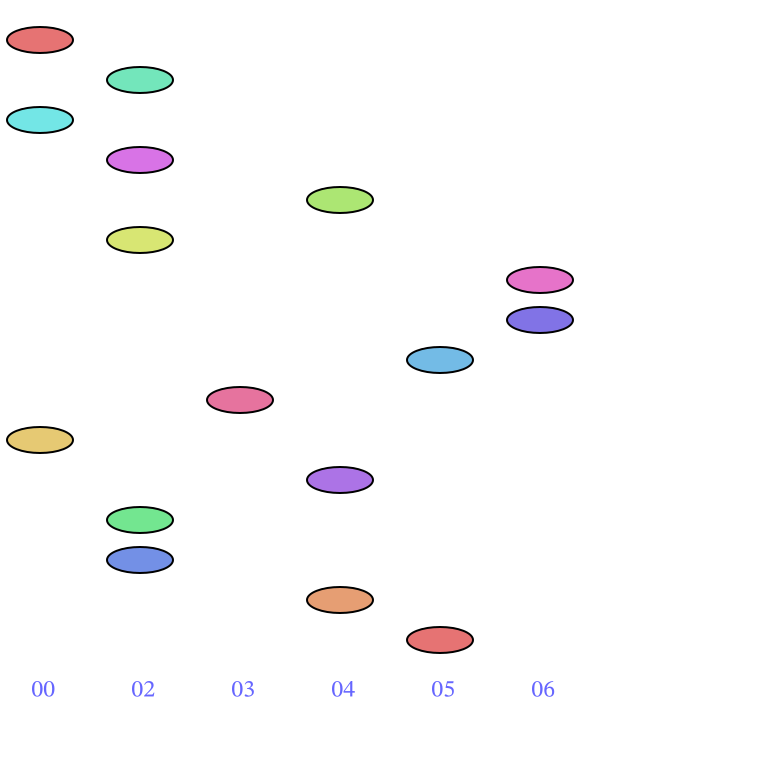

In [4]:
svg = psc.subsets2svg(virtual_uses)
SVG(data=svg)

In [5]:
def get_model(instruction_uses, phys_regs_costs, virtual_regs_amount):
    model = pyo.ConcreteModel()
    
    # Множество физических регистров
    model.phys_regs = pyo.Set(initialize=range(len(phys_regs_costs)))
    
    # Сопоставление каждому физическому регистру его стоимости  -- не совсем понятно, зачем нам параметры в конкретной модели
    model.phys_costs = pyo.Param(model.phys_regs, initialize=phys_regs_costs)
    
    # Множество виртуальных регистров
    model.virt_regs = pyo.Set(initialize=range(virtual_regs_amount))
    
    # Хотим составить отображение из виртуальных регистров на физические
    model.alloca = pyo.Var(model.virt_regs, model.phys_regs, domain=pyo.Binary)
    
    # Составляем множества плохих пар виртуальных регистров (встречаемых в используемых для одинаковых инструкций)
    model.bad_pairs = pyo.Set(  # !!! плохой пример — получается пустое множество. ij — символы, очень мутно
        initialize=sorted(set([(int(i), int(j)) for uses in instruction_uses for i in uses for j in uses if i < j])))
    
    # ЦЕЛЬ: минимизировать стоимость использования физических регистров после аллокации
    model.obj = pyo.Objective(expr=sum(model.phys_costs[p] * model.alloca[v, p] 
                                for v in model.virt_regs 
                                for p in model.phys_regs))
    
    # ОГРАНИЧЕНИЕ: каждому виртуальному регистру сопоставляем ровно 1 физический
    @model.Constraint(model.virt_regs)
    def виртуальному_один_физический(m, v):
        return sum(model.alloca[v, phys] for phys in m.phys_regs) == 1
    
    # ОГРАНИЧЕНИЕ: каждый физический регистр должен использоваться каждой инструкцией не более одного раза
    @model.Constraint(model.bad_pairs, model.phys_regs)
    def использование_одного_физического(m, first, second, reg):
        return (m.alloca[first, reg] + m.alloca[second, reg]) <= 1
    
    # @model.Constraint(range(8))
    # def wtf(m, в):
    #     if в==0:
    #         return model.alloca[в, 1] == 1
    #     elif в==1:
    #         return model.alloca[в, 0] == 1
    #     elif в==2:
    #         return model.alloca[в, 2] == 1
    #     elif в==3:
    #         return model.alloca[в, 0] == 1
    #     elif в==4:
    #         return model.alloca[в, 3] == 1
    #     elif в==5:
    #         return model.alloca[в, 1] == 1
    #     elif в==6:
    #         return model.alloca[в, 0] == 1
    #     elif в==7:
    #         return model.alloca[в, 0] == 1
    #     return  pyo.Constraint.Skip
    
    return model
    

In [6]:
m = get_model(virtual_uses, phys_regs_costs, len(virtual_alives))
m.pprint()

3 Set Declarations
    bad_pairs : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :    -- :    Any :    0 :      {}
    phys_regs : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    virt_regs : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    9 : {0, 1, 2, 3, 4, 5, 6, 7, 8}

1 Param Declarations
    phys_costs : Size=3, Index=phys_regs, Domain=Any, Default=None, Mutable=False
        Key : Value
          0 :     1
          1 :     2
          2 :     3

1 Var Declarations
    alloca : Size=27, Index=virt_regs*phys_regs
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
       

In [7]:
solver = pyo.SolverFactory('cbc')
solver.solve(m).write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 9.0
  Upper bound: 9.0
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 27
  Number of binary variables: 27
  Number of integer variables: 27
  Number of nonzeros: 27
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
    

In [8]:
#m.alloca.extract_values()
pretty_solution(m, skip_zeros=True)

alloca 
 
 
 
 
 0 
 0 
 1.0 
 
 
 1 
 0 
 1.0 
 
 
 2 
 0 
 1.0 
 
 
 3 
 0 
 1.0 
 
 
 4 
 0 
 1.0 
 
 
 5 
 0 
 1.0 
 
 
 6 
 0 
 1.0 
 
 
 7 
 0 
 1.0 
 
 
 8 
 0 
 1.0

In [9]:
for v in m.component_data_objects(pyo.Var):
    if v.value and v.value > 0:
        print(str(v), v.value)

alloca[0,0] 1.0
alloca[1,0] 1.0
alloca[2,0] 1.0
alloca[3,0] 1.0
alloca[4,0] 1.0
alloca[5,0] 1.0
alloca[6,0] 1.0
alloca[7,0] 1.0
alloca[8,0] 1.0


In [10]:
def модель(инструкции, стоимость_регистров):
    m = pyo.ConcreteModel()
    m.В  = sorted(set([в for и in инструкции for в in и]))
    m.Ф  = range(len(стоимость_регистров))
    m.I  = range(len(инструкции))
    m.вирт2физ = pyo.Var(m.В, m.Ф, domain=pyo.Binary)
    
    @m.Objective()
    def стоимость_аренды(m, в):
        return sum(стоимость_регистров[ф] * m.вирт2физ[в, ф] for в in m.В for ф in m.Ф)
    
    @m.Constraint(m.В)
    def виртуальному_один_физический(m, в):
        return sum(m.вирт2физ[в, ...]) == 1

    @m.Constraint(m.Ф, m.I)
    def в_каждой_инструкции_мапировать_не_больше_чем_в_один_физический(m, ф, i):
        вирт_регистры = sorted(set(инструкции[i]))
        выражение = 0 
        for имя_регистра in вирт_регистры:
            выражение += m.вирт2физ[имя_регистра, ф]
        return выражение <= 1
   
    return m


In [11]:
m2 = модель(virtual_uses, phys_regs_costs)
#m2.pprint()
solver = pyo.SolverFactory('cbc')
solver.solve(m2).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 6.0
  Upper bound: 6.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 18
  Number of binary variables: 18
  Number of integer variables: 18
  Number of nonzeros: 18
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
    

In [12]:
virtual_uses


[['00'],
 ['02'],
 ['00'],
 ['02'],
 ['04'],
 ['02'],
 ['06'],
 ['06'],
 ['05'],
 ['03'],
 ['00'],
 ['04'],
 ['02'],
 ['02'],
 ['04'],
 ['05']]

In [13]:

pretty_solution(m2, skip_zeros=True)

вирт2физ 
 
 
 
 
 00 
 0 
 1.0 
 
 
 02 
 0 
 1.0 
 
 
 03 
 0 
 1.0 
 
 
 04 
 0 
 1.0 
 
 
 05 
 0 
 1.0 
 
 
 06 
 0 
 1.0

Визуализируем используемые регистры инструкций после аллокации \(заменим виртуальные регистры на физические\)


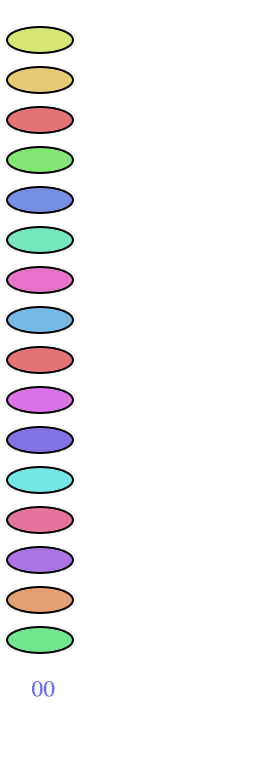

In [14]:
phys_uses = []
for use in virtual_uses:
    phys_uses.append([f"{p:02}" for v in use for p in range(phys_regs_amount) if pyo.value(m.alloca[int(v), p])])
svg = psc.subsets2svg(phys_uses)
SVG(data=svg)

In [15]:
sat_vars_amount = 5
sat_clauses_amount = 20

cnf3 = CNF(from_clauses=psc.rand3cnf(sat_clauses_amount, sat_vars_amount))
cnf3.clauses

[(4, 3, -2),
 (5, 3, 2),
 (-3, -4, -5),
 (4, 5, 1),
 (3, -2, -5),
 (-4, 1, 2),
 (3, 5, 4),
 (-5, -4, 1),
 (-2, 3, 1),
 (1, -2, -5),
 (-2, -4, -3),
 (-2, -4, -1),
 (5, -1, -2),
 (-3, -1, -5),
 (-3, -5, 1),
 (1, -5, -3),
 (3, 2, 5),
 (2, -3, -4),
 (-5, 3, 2),
 (4, 2, -5)]

In [16]:
solver = Solver(bootstrap_with=cnf3)
res = solver.solve()
res

True

[Лекция о сведении Graph-coloring к 3SAT](https://www.youtube.com/watch?app=desktop&v=B5_m8lKULlI)

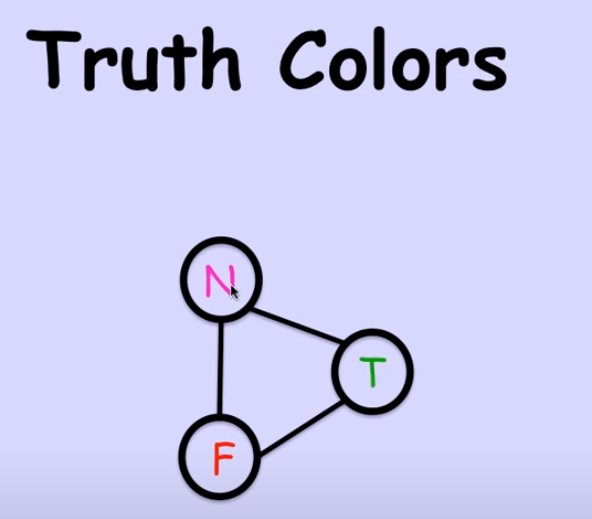

In [17]:
NEUTRAL = 0
TRUE = 1
FALSE = 2

vertexes_amount = 3
edges = [(NEUTRAL, TRUE), (TRUE, FALSE), (FALSE, NEUTRAL)]

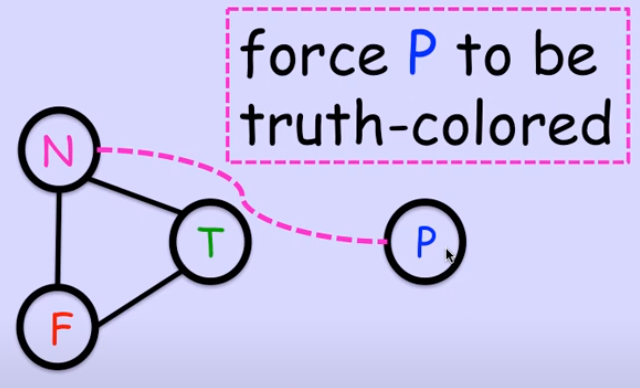

In [18]:
def create_var():
    global vertexes_amount
    
    new_var = vertexes_amount
    vertexes_amount += 1

    return new_var

def ident_var():
    global edges

    new_var = create_var()
    edges.append((new_var, NEUTRAL))

    return new_var

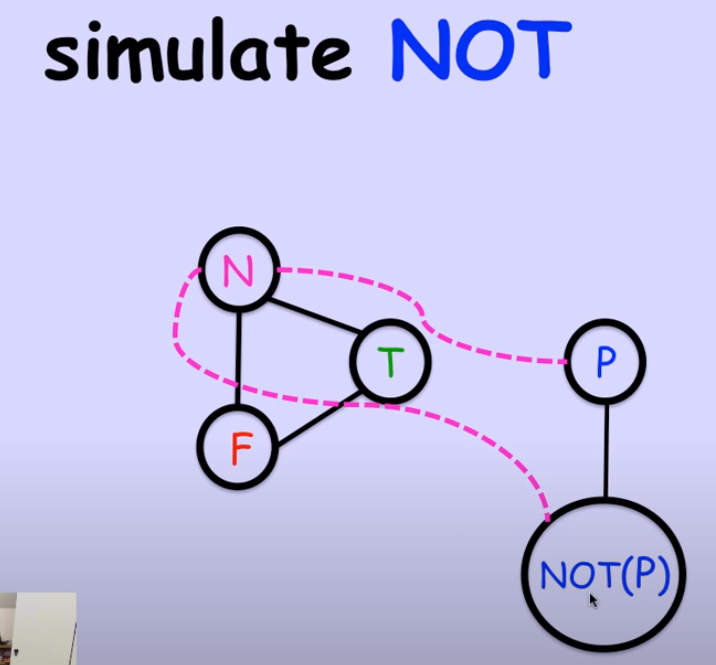

In [19]:
def negate_var(to_negate):
    global edges
    
    negative_var = ident_var()
    edges.append((negative_var, to_negate))

    return negative_var

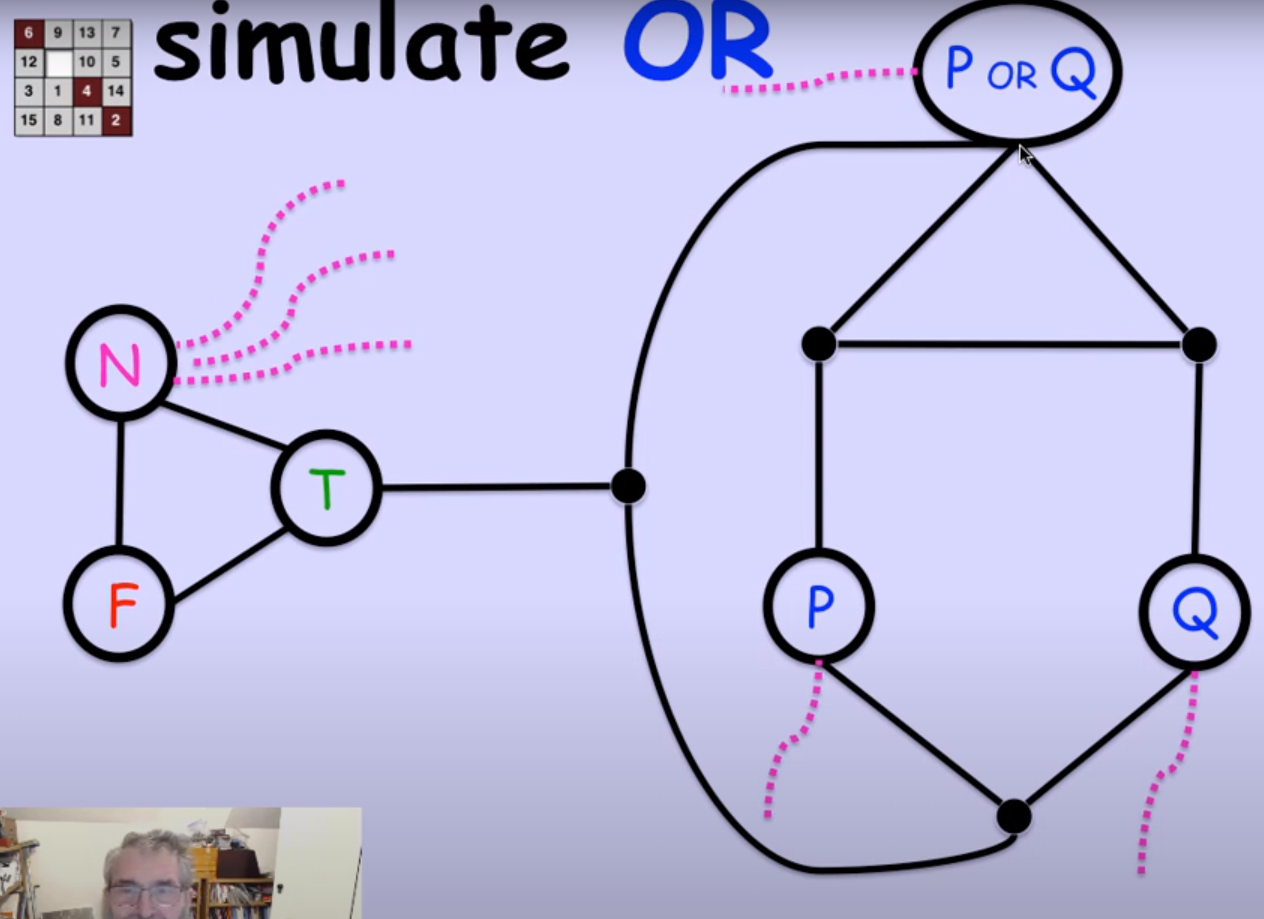

In [20]:
def or_var(lhs, rhs):
    global edges
    global vertexes_amount

    res_var = ident_var()

    tmps = list(range(vertexes_amount, vertexes_amount + 4))
    vertexes_amount += 4

    edges.append((TRUE, tmps[0]))

    edges.append((tmps[0], tmps[1]))
    edges.append((tmps[0], res_var))

    edges.append((tmps[1], lhs))
    edges.append((tmps[1], rhs))

    edges.append((lhs, tmps[2]))
    edges.append((rhs, tmps[3]))

    edges.append((tmps[2], tmps[3]))
    edges.append((tmps[2], res_var))
    edges.append((tmps[3], res_var))

    return res_var

In [21]:
import functools

var_converter = {}
for sat_var in range(1, sat_vars_amount + 1):
    var_converter[sat_var] = ident_var()

negate_converter = {}
for sat_var in range(1, sat_vars_amount + 1):
    negate_converter[sat_var] = negate_var(var_converter[sat_var])

converted_clauses = []
for clause in cnf3.clauses:
    converted_clauses.append(functools.reduce(or_var, map(lambda x: var_converter[x] if x > 0 else negate_converter[-x], clause)))

for clause in converted_clauses:
    edges.append((clause, NEUTRAL))
    edges.append((clause, FALSE))

In [22]:
m = get_model(edges, phys_regs_costs, vertexes_amount)
m.pprint()

In [23]:
cbc_solver = pyo.SolverFactory('cbc')
cbc_solver.solve(m).write()

false_reg = [p for p in range(phys_regs_amount) if pyo.value(m.alloca[FALSE, p])]
true_reg = [p for p in range(phys_regs_amount) if pyo.value(m.alloca[TRUE, p])]

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 396.0
  Upper bound: 396.0
  Number of objectives: 1
  Number of constraints: 1647
  Number of variables: 639
  Number of binary variables: 639
  Number of integer variables: 639
  Number of nonzeros: 639
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 7.02
  Wallclock time: 7.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and

In [24]:
false_reg = false_reg[0]
true_reg = true_reg[0]

answer = []
for sat_var in range(1, sat_vars_amount + 1):
    is_false = pyo.value(m.alloca[var_converter[sat_var], false_reg])
    is_true = pyo.value(m.alloca[var_converter[sat_var], true_reg])
    
    assert(is_false or is_true)
    if is_true:
        answer.append(sat_var)
    else:
        answer.append(-sat_var)

print(answer)
print(list(solver.enum_models()))

[1, -2, 3, -4, -5]
[[1, -2, 3, -4, -5]]
